# Introduction to GWR and MGWR

Note: This tutorial is largely based on Oshan, T. M., Li, Z., Kang, W., Wolf, L. J., & Fotheringham, A. S. (2019).[ mgwr: A Python implementation of multiscale geographically weighted regression for investigating process spatial heterogeneity and scale](https://www.mdpi.com/2220-9964/8/6/269/html). ISPRS International Journal of Geo-Information, 8(6), 269. 

## Setup

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5)
sns.set(font="serif")

import geopandas as gpd
import libpysal as ps   # used for ps.examples.get_path('G_utm.shp')

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

import warnings
warnings.filterwarnings('ignore')
import time

# Jupyter display settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import data

In [2]:
# Load Georgia dataset 
gdf  = gpd.read_file(ps.examples.get_path('G_utm.shp'))

In [3]:
gdf.columns

Index(['AREA', 'PERIMETER', 'G_UTM_', 'G_UTM_ID', 'Latitude', 'Longitud',
       'TotPop90', 'PctRural', 'PctBach', 'PctEld', 'PctFB', 'PctPov',
       'PctBlack', 'X', 'Y', 'AreaKey', 'geometry'],
      dtype='object')

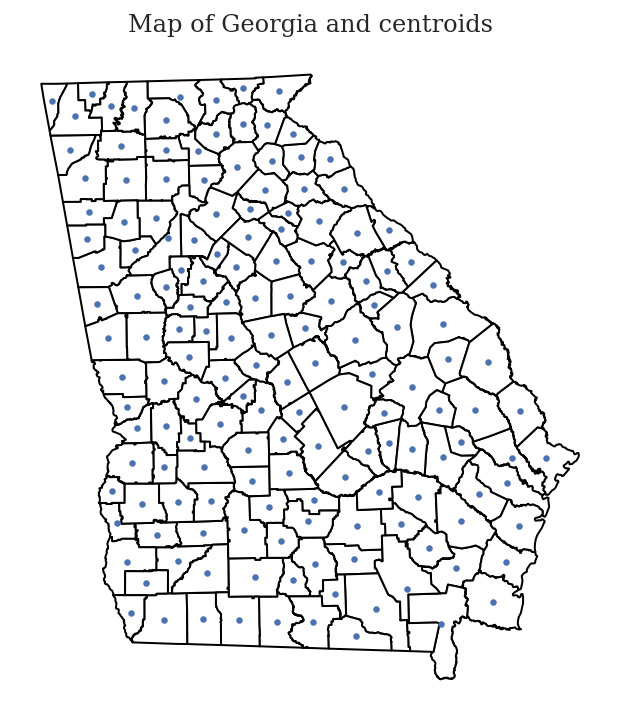

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(color = 'white', edgecolor = 'black', ax = ax)
gdf.centroid.plot(ax=ax, markersize=5)
ax.set_title('Map of Georgia and centroids')
ax.axis("off")
plt.show()

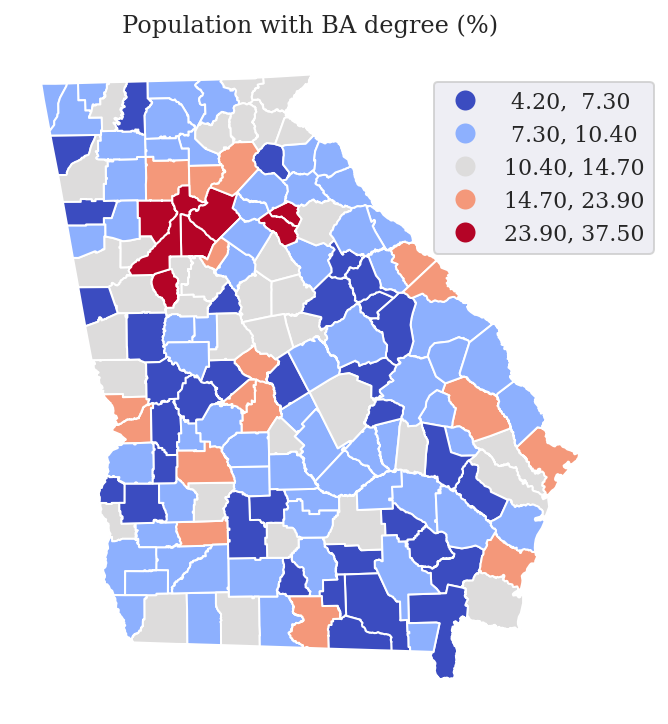

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(column='PctBach', 
         cmap = 'coolwarm', 
         scheme = 'FisherJenks', k=5, 
         legend=True, 
         legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  
         ax=ax)
ax.set_title('Population with BA degree (%)')
ax.axis("off")
plt.show()

## Select variables (y, X)

- `PctBach` — percent of adults with a BA degree (%).
- `PctFB` — percent foreign-born (%).
- `PctBlack` — percent African American (%).
- `PctRural` — percent living in rural areas (%).

In [6]:
y = gdf['PctBach'].values.reshape((-1,1)) # reshape is needed to have column array
y.shape

(159, 1)

In [7]:
X = gdf[['PctFB', 'PctBlack', 'PctRural']].values
X.shape

(159, 3)

## Define coordinates (u,v)

In the data frame, the coordinates are already projected, so we can use Euclidian distances.

In [8]:
u = gdf['X']
v = gdf['Y']
coords = list(zip(u,v))

## Estimate GWR model

### Select GWR bandwidth 


The default search is based on the AICc criteria and the Bi-square kernel.

The Bi-square kernel weights nearby data points more heavily, helping capture meaningful spatial variation.

In [9]:
%%time
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()

CPU times: user 191 ms, sys: 129 ms, total: 320 ms
Wall time: 2.78 s


In [10]:
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 117.0


### Fit GWR model

In [11]:
gwr_results = GWR(coords, y, X, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 159
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2315.466
Log-likelihood:                                                    -438.549
AIC:                                                                885.098
AICc:                                                               887.490
BIC:                                                               1529.786
R2:                                                                   0.548
Adj. R2:                                                              0.540

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [12]:
# As reference, here is the (average) R2, AIC, and AICc
print('Mean R2 =', gwr_results.R2)
print('AIC =', gwr_results.aic)
print('AICc =', gwr_results.aicc)

Mean R2 = 0.6780742669593459
AIC = 848.9154070534354
AICc = 851.350292784466


In [13]:
# Add R2 to GeoDataframe 
gdf['gwr_R2'] = gwr_results.localR2

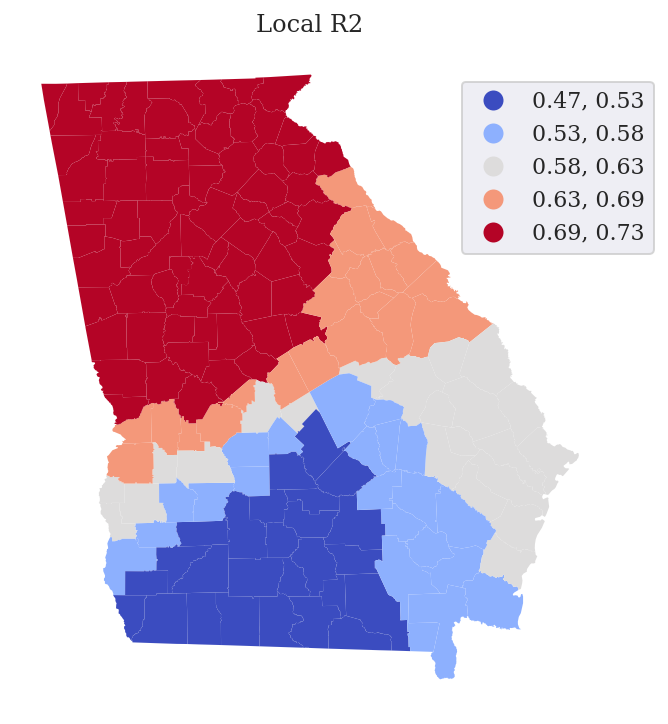

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(column='gwr_R2', 
         cmap = 'coolwarm', 
         linewidth=0.01, 
         scheme = 'FisherJenks', 
         k=5, 
         legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local R2', fontsize=12)
ax.axis("off")
plt.show()

### Add coefficients to data frame

In [15]:
gdf['gwr_intercept'] = gwr_results.params[:,0]
gdf['gwr_fb']        = gwr_results.params[:,1]
gdf['gwr_aa']        = gwr_results.params[:,2]
gdf['gwr_rural']     = gwr_results.params[:,3]

### Filter/correct t-stats

In [16]:
# Filter t-values: standard alpha = 0.05
gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)

In [17]:
pd.DataFrame(gwr_filtered_t)

,0,1,2,3
0,7.575212,2.043092,0.000000,-5.275729
1,7.867274,0.000000,0.000000,-5.394243
2,7.721605,0.000000,0.000000,-5.391188
3,7.289409,0.000000,0.000000,-4.320395
4,6.993196,8.464020,-2.249061,-2.736049
...,...,...,...,...
154,6.551971,8.743662,0.000000,-3.043554
155,7.090166,2.581231,0.000000,-4.349220
156,7.010192,7.850315,-2.216092,-3.352082
157,6.657729,7.512685,0.000000,-2.722907


In [18]:
# Filter t-values: corrected alpha due to multiple testing
gwr_filtered_tc = gwr_results.filter_tvals()

In [19]:
pd.DataFrame(gwr_filtered_tc)

,0,1,2,3
0,7.575212,0.000000,0.0,-5.275729
1,7.867274,0.000000,0.0,-5.394243
2,7.721605,0.000000,0.0,-5.391188
3,7.289409,0.000000,0.0,-4.320395
4,6.993196,8.464020,0.0,-2.736049
...,...,...,...,...
154,6.551971,8.743662,0.0,-3.043554
155,7.090166,2.581231,0.0,-4.349220
156,7.010192,7.850315,0.0,-3.352082
157,6.657729,7.512685,0.0,-2.722907


### Map coefficients

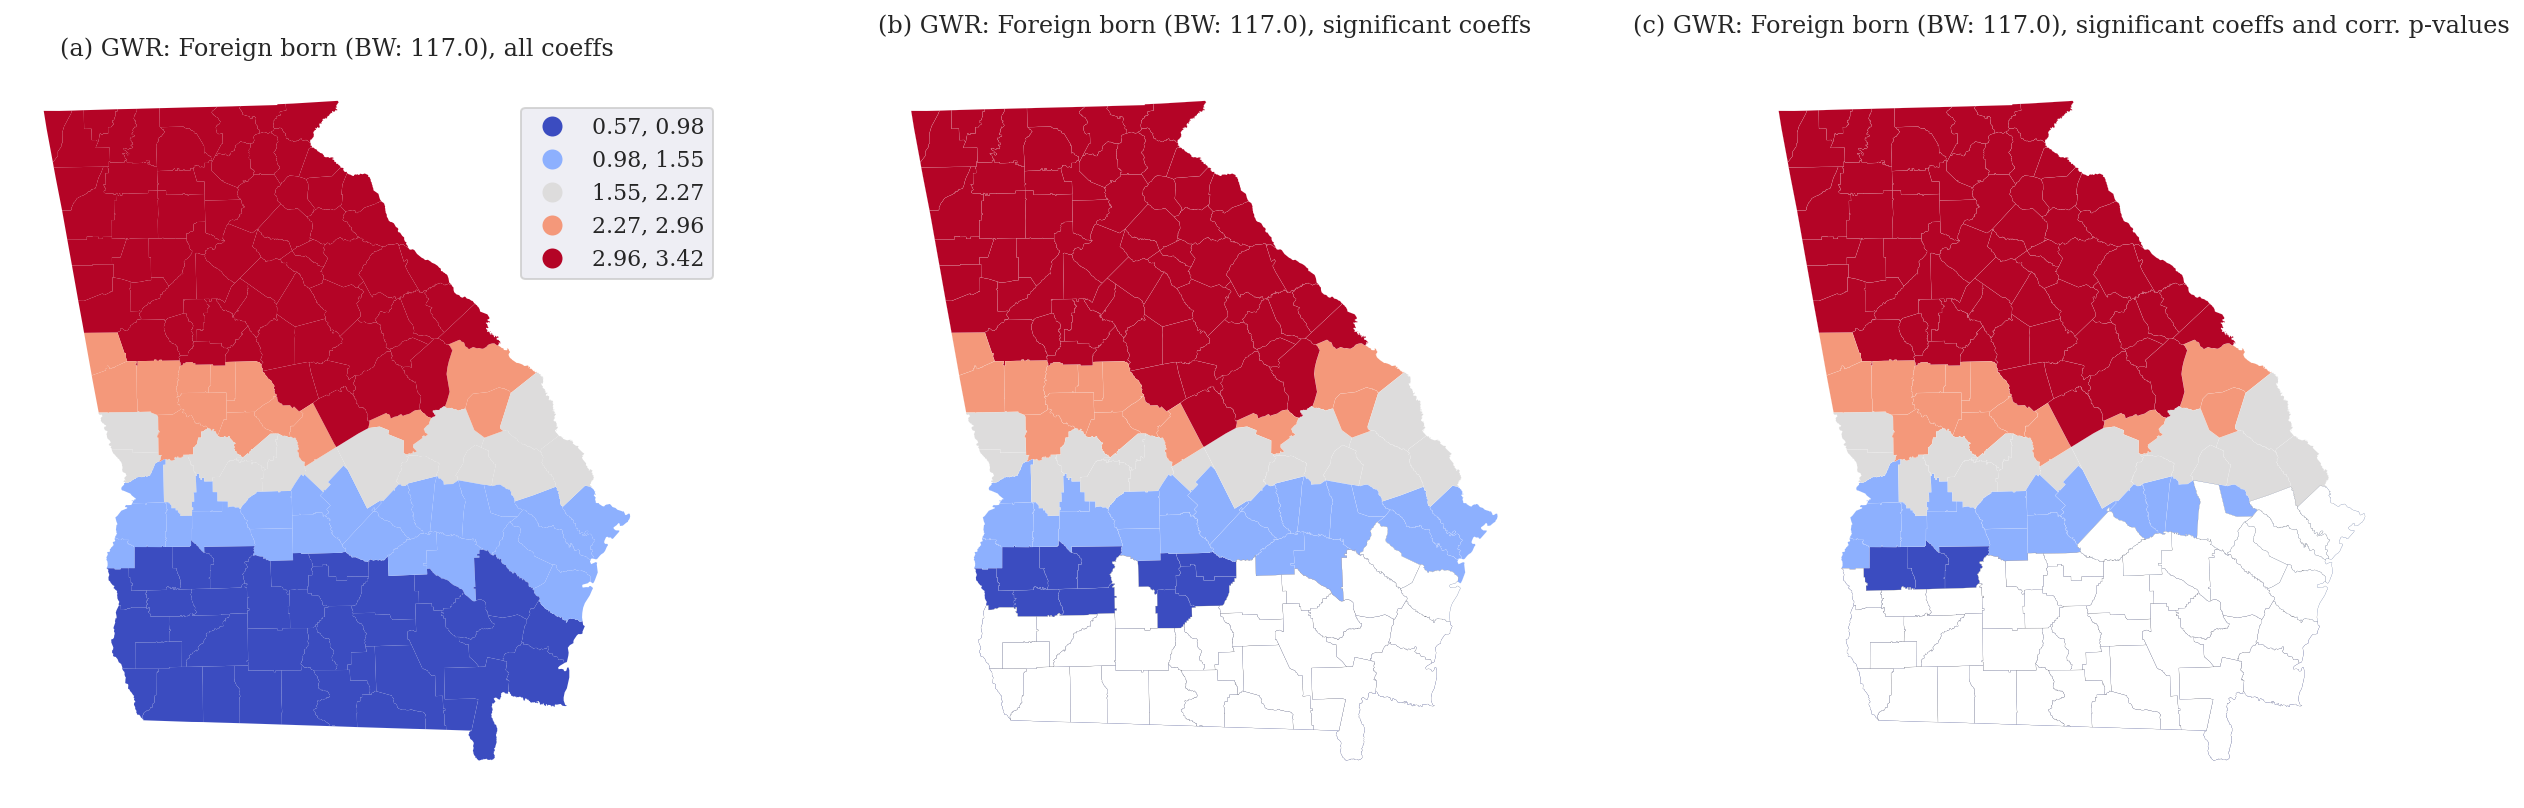

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

gdf.plot(column='gwr_fb', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])

gdf.plot(column='gwr_fb', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
gdf[gwr_filtered_t[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


gdf.plot(column='gwr_fb', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
gdf[gwr_filtered_tc[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Foreign born (BW: ' + str(gwr_bw) +'), all coeffs')
axes[1].set_title('(b) GWR: Foreign born (BW: ' + str(gwr_bw) +'), significant coeffs')
axes[2].set_title('(c) GWR: Foreign born (BW: ' + str(gwr_bw) +'), significant coeffs and corr. p-values')
plt.show()

### Test spatial stationarity

In [21]:
%%time
# Monte Carlo test of spatial variability: 100 iterations 
gwr_p_values_stationarity = gwr_results.spatial_variability(gwr_selector, 100)

Testing:   0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 15.9 s, sys: 3.03 s, total: 19 s
Wall time: 22.5 s


In [22]:
gwr_p_values_stationarity
# Note:  The first p-value is for the intercept

array([0.83, 0.11, 0.17, 0.57])

- The p-value for the intercept, african american, and the rural variables are larger than 0.05, so for these  cases the parameter estimates exhibit NO significant local variation. 
- The p-values for foreign born is smaller than 0.05, so the parameter estimates do exhibit significant local variation 

### Test local multicollinearity

In [23]:
LCC, VIF, CN, VDP = gwr_results.local_collinearity()

In [24]:
pd.DataFrame(VIF)

,0,1,2
0,1.182403,1.021370,1.165372
1,1.147264,1.031686,1.123968
2,1.167971,1.024843,1.150307
3,1.279951,1.066151,1.209409
4,1.839177,1.061996,1.767668
...,...,...,...
154,1.797506,1.043939,1.856022
155,1.224661,1.049290,1.171810
156,1.974087,1.091131,1.898749
157,1.590199,1.062448,1.546565


In [25]:
pd.DataFrame(VIF).describe().round(2)

,0,1,2
count,159.00,159.00,159.00
mean,1.63,1.05,1.60
std,0.36,0.02,0.37
min,1.14,1.01,1.12
25%,1.26,1.03,1.22
50%,1.69,1.05,1.62
75%,1.92,1.06,1.94
max,2.25,1.10,2.23


As the max VIF for each variable is less than 10, there are no signs of local multicollinearity

In [26]:
pd.DataFrame(CN)

,0
0,10.785767
1,11.302612
2,10.989433
3,10.652863
4,11.517788
...,...
154,10.324951
155,11.252857
156,12.273432
157,11.233989


In [27]:
gdf['gwr_CN'] = CN

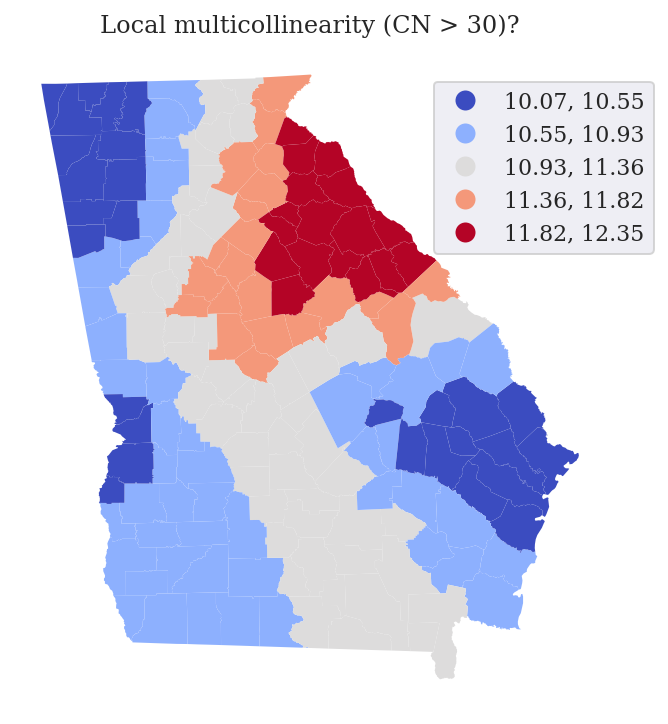

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(column='gwr_CN', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local multicollinearity (CN > 30)?', fontsize=12)
ax.axis("off")
plt.show()

As the CD is less than 30, there are no signs of local multicollinearity

## Estimate MGWR model

### Standardize variables

These variables will be needed for the MGWR

In [29]:
Zy = (y - y.mean(axis=0)) / y.std(axis=0)
ZX = (X - X.mean(axis=0)) / X.std(axis=0)

### Select MGWR bandwidths

In [30]:
mgwr_selector = Sel_BW(coords, Zy, ZX, multi=True)
mgwr_bw = mgwr_selector.search()
mgwr_bw

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

array([101., 101., 117., 157.])

### Fit MGWR model

In [31]:
mgwr_results = MGWR(coords, Zy, ZX, mgwr_selector).fit()
mgwr_results.summary()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                 159
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             71.793
Log-likelihood:                                                    -162.399
AIC:                                                                332.798
AICc:                                                               335.191
BIC:                                                               -713.887
R2:                                                                   0.548
Adj. R2:                                                              0.540

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Show bandwidth intervals

In [32]:
mgwr_bw_ci = mgwr_results.get_bws_intervals(mgwr_selector)
print(mgwr_bw_ci)

[(np.float64(87.0), np.float64(104.0)), (np.float64(87.0), np.float64(104.0)), (np.float64(114.0), np.float64(117.0)), (np.float64(114.0), np.float64(157.0))]


### Add coefficients to data frame

In [33]:
#Add MGWR parameters to GeoDataframe
gdf['mgwr_intercept'] = mgwr_results.params[:,0]
gdf['mgwr_fb']        = mgwr_results.params[:,1]
gdf['mgwr_aa']        = mgwr_results.params[:,2]
gdf['mgwr_rural']     = mgwr_results.params[:,3]

### Filter/correct t-stats

In [34]:
# Filter t-values: standard alpha = 0.05
mgwr_filtered_t = mgwr_results.filter_tvals(alpha = 0.05)

In [35]:
# Filter t-values: corrected alpha due to multiple testing
mgwr_filtered_tc = mgwr_results.filter_tvals()

### Map coefficients

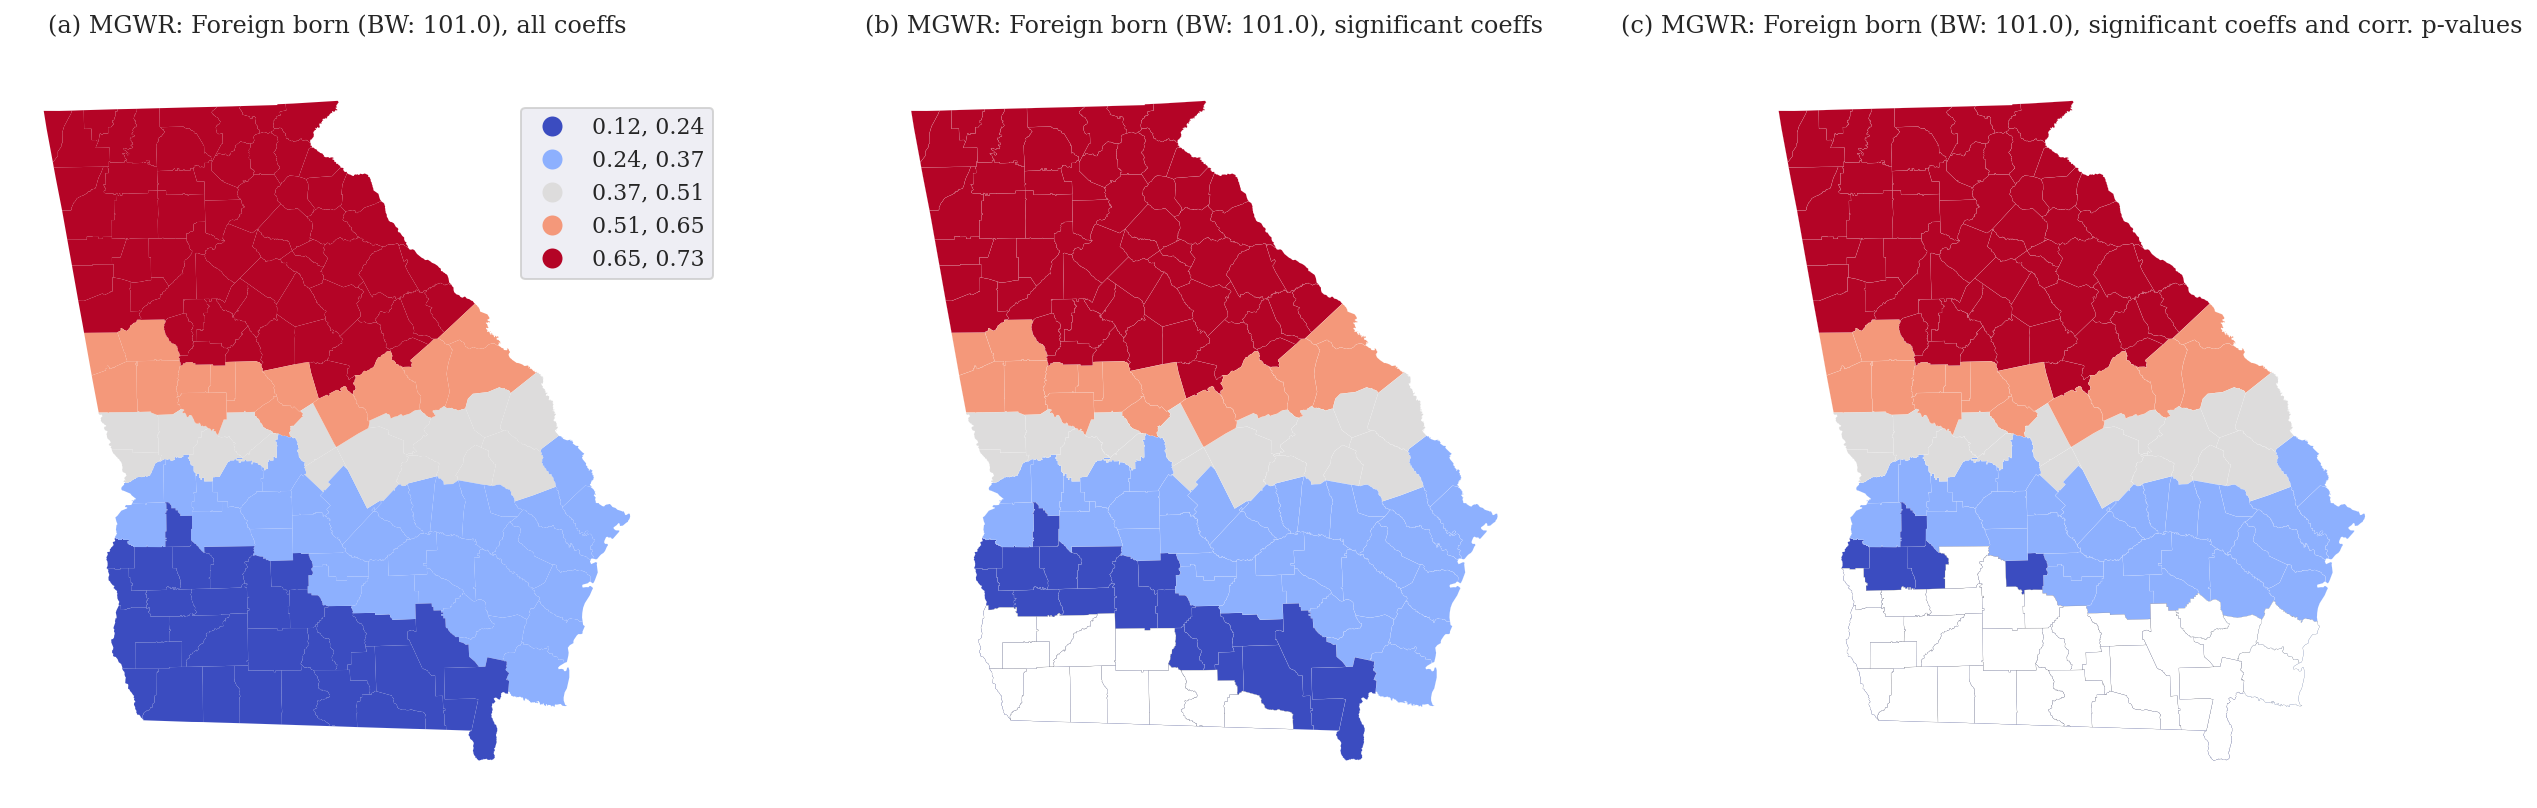

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

gdf.plot(column='mgwr_fb', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])

gdf.plot(column='mgwr_fb', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
gdf[mgwr_filtered_t[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])

gdf.plot(column='mgwr_fb', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
gdf[mgwr_filtered_tc[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) MGWR: Foreign born (BW: ' + str(mgwr_bw[1]) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) MGWR: Foreign born (BW: ' + str(mgwr_bw[1]) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) MGWR: Foreign born (BW: ' + str(mgwr_bw[1]) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()

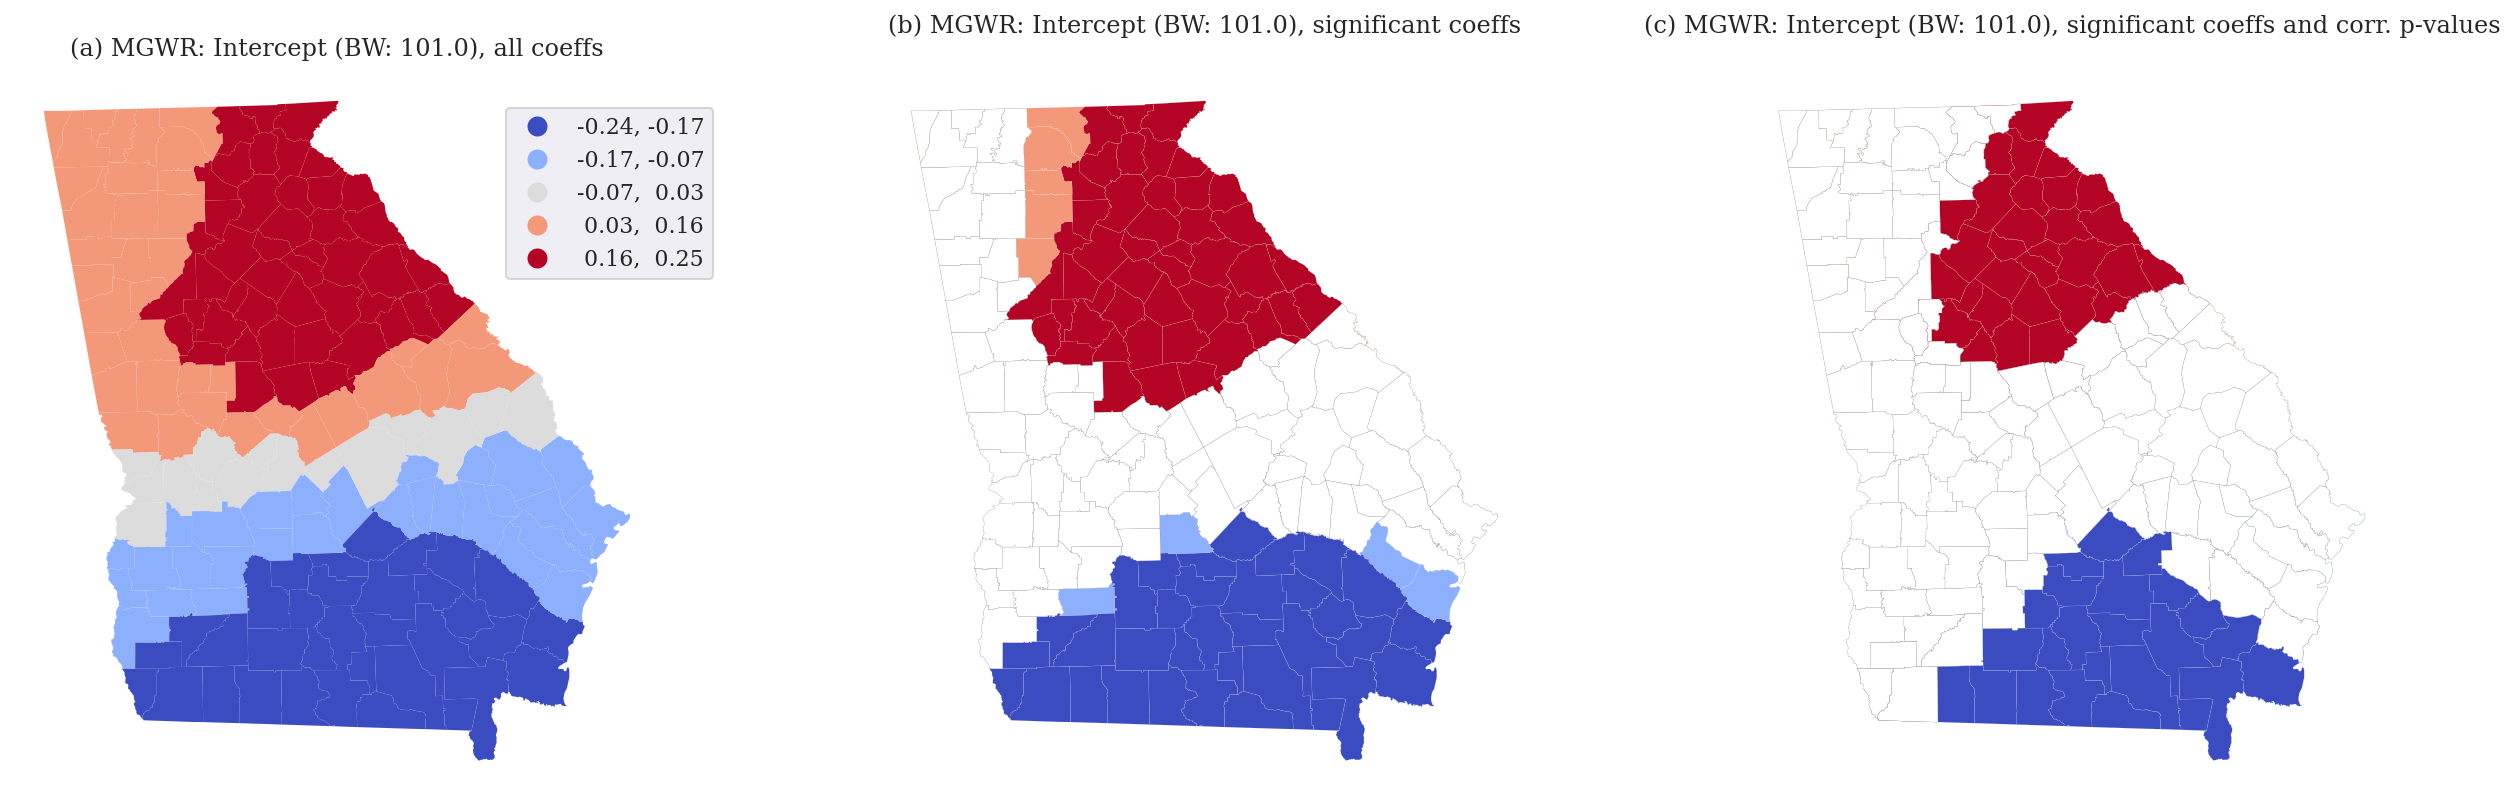

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

gdf.plot(column='mgwr_intercept', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])

gdf.plot(column='mgwr_intercept', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
gdf[mgwr_filtered_t[:,0] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


gdf.plot(column='mgwr_intercept', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
gdf[mgwr_filtered_tc[:,0] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) MGWR: Intercept (BW: ' + str(mgwr_bw[0]) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) MGWR: Intercept (BW: ' + str(mgwr_bw[0]) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) MGWR: Intercept (BW: ' + str(mgwr_bw[0]) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()

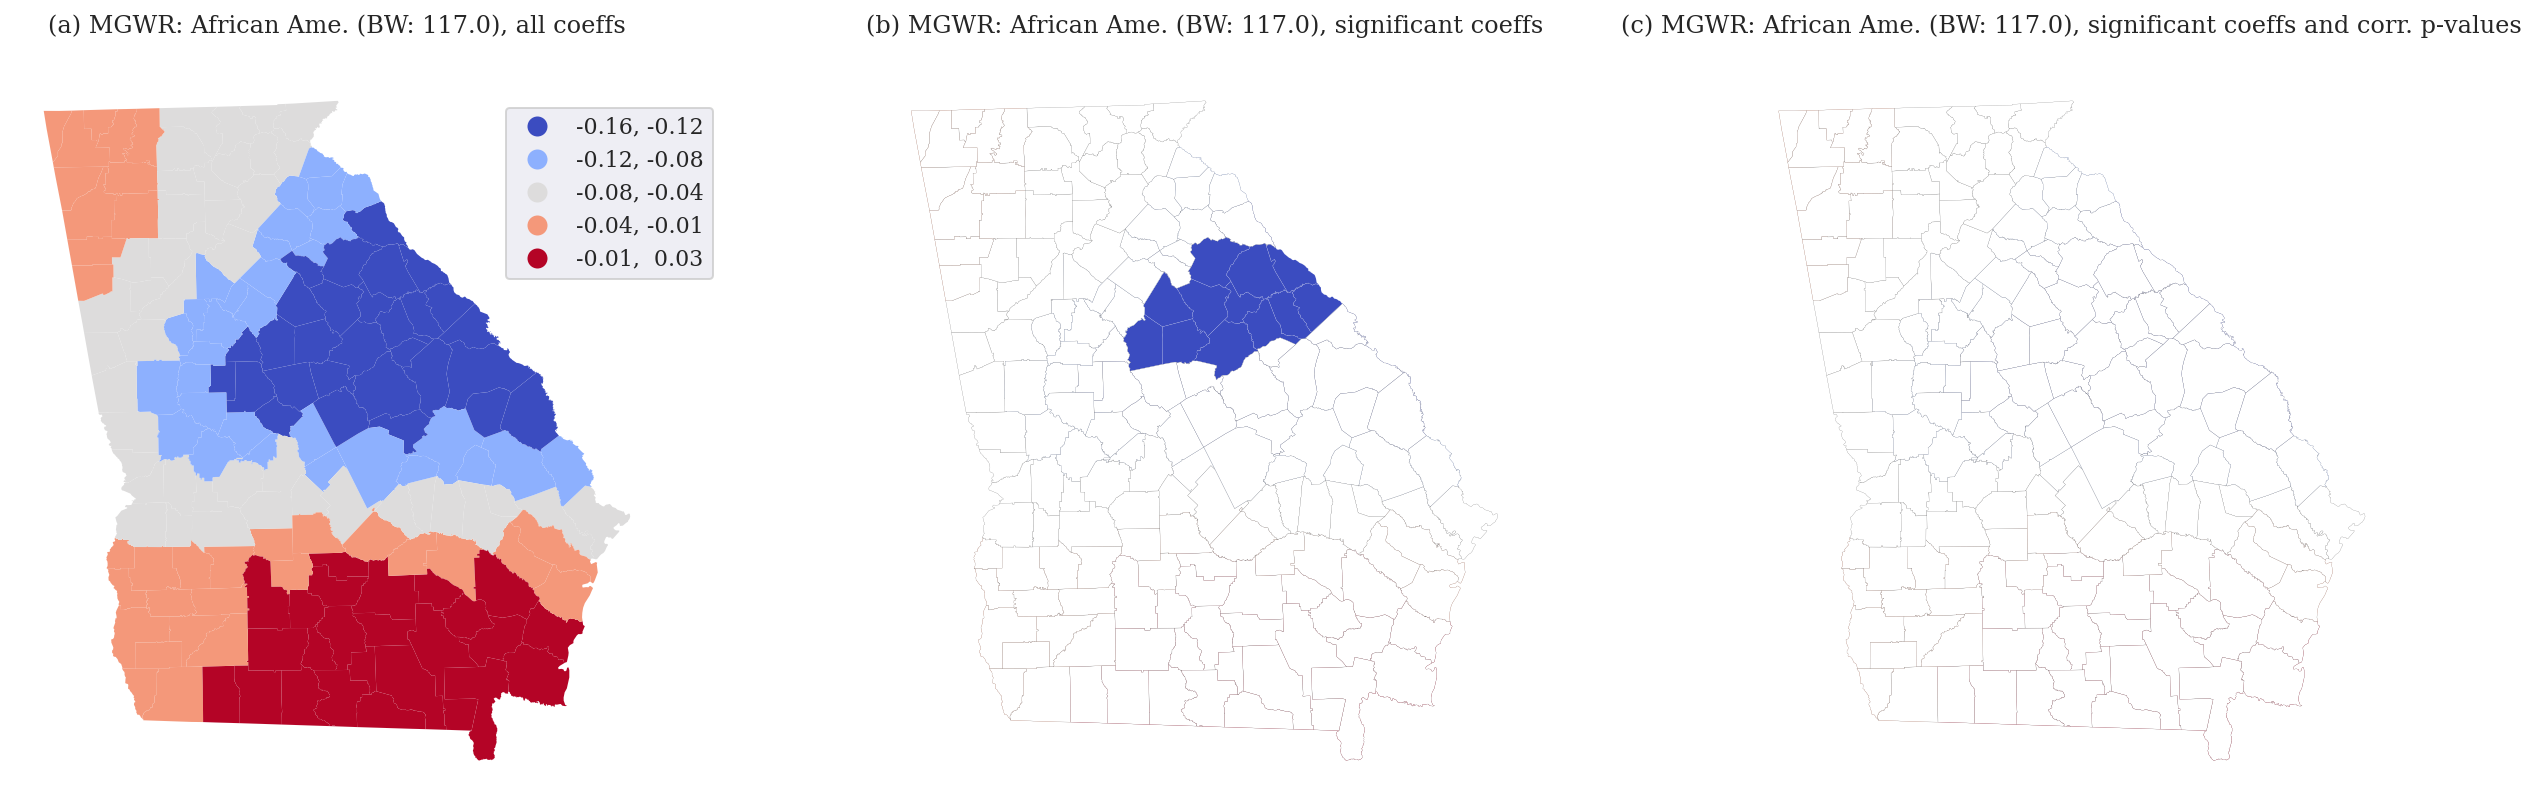

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

gdf.plot(column='mgwr_aa', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])

gdf.plot(column='mgwr_aa', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
gdf[mgwr_filtered_t[:,2] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


gdf.plot(column='mgwr_aa', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
gdf[mgwr_filtered_tc[:,2] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) MGWR: African Ame. (BW: ' + str(mgwr_bw[2]) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) MGWR: African Ame. (BW: ' + str(mgwr_bw[2]) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) MGWR: African Ame. (BW: ' + str(mgwr_bw[2]) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()

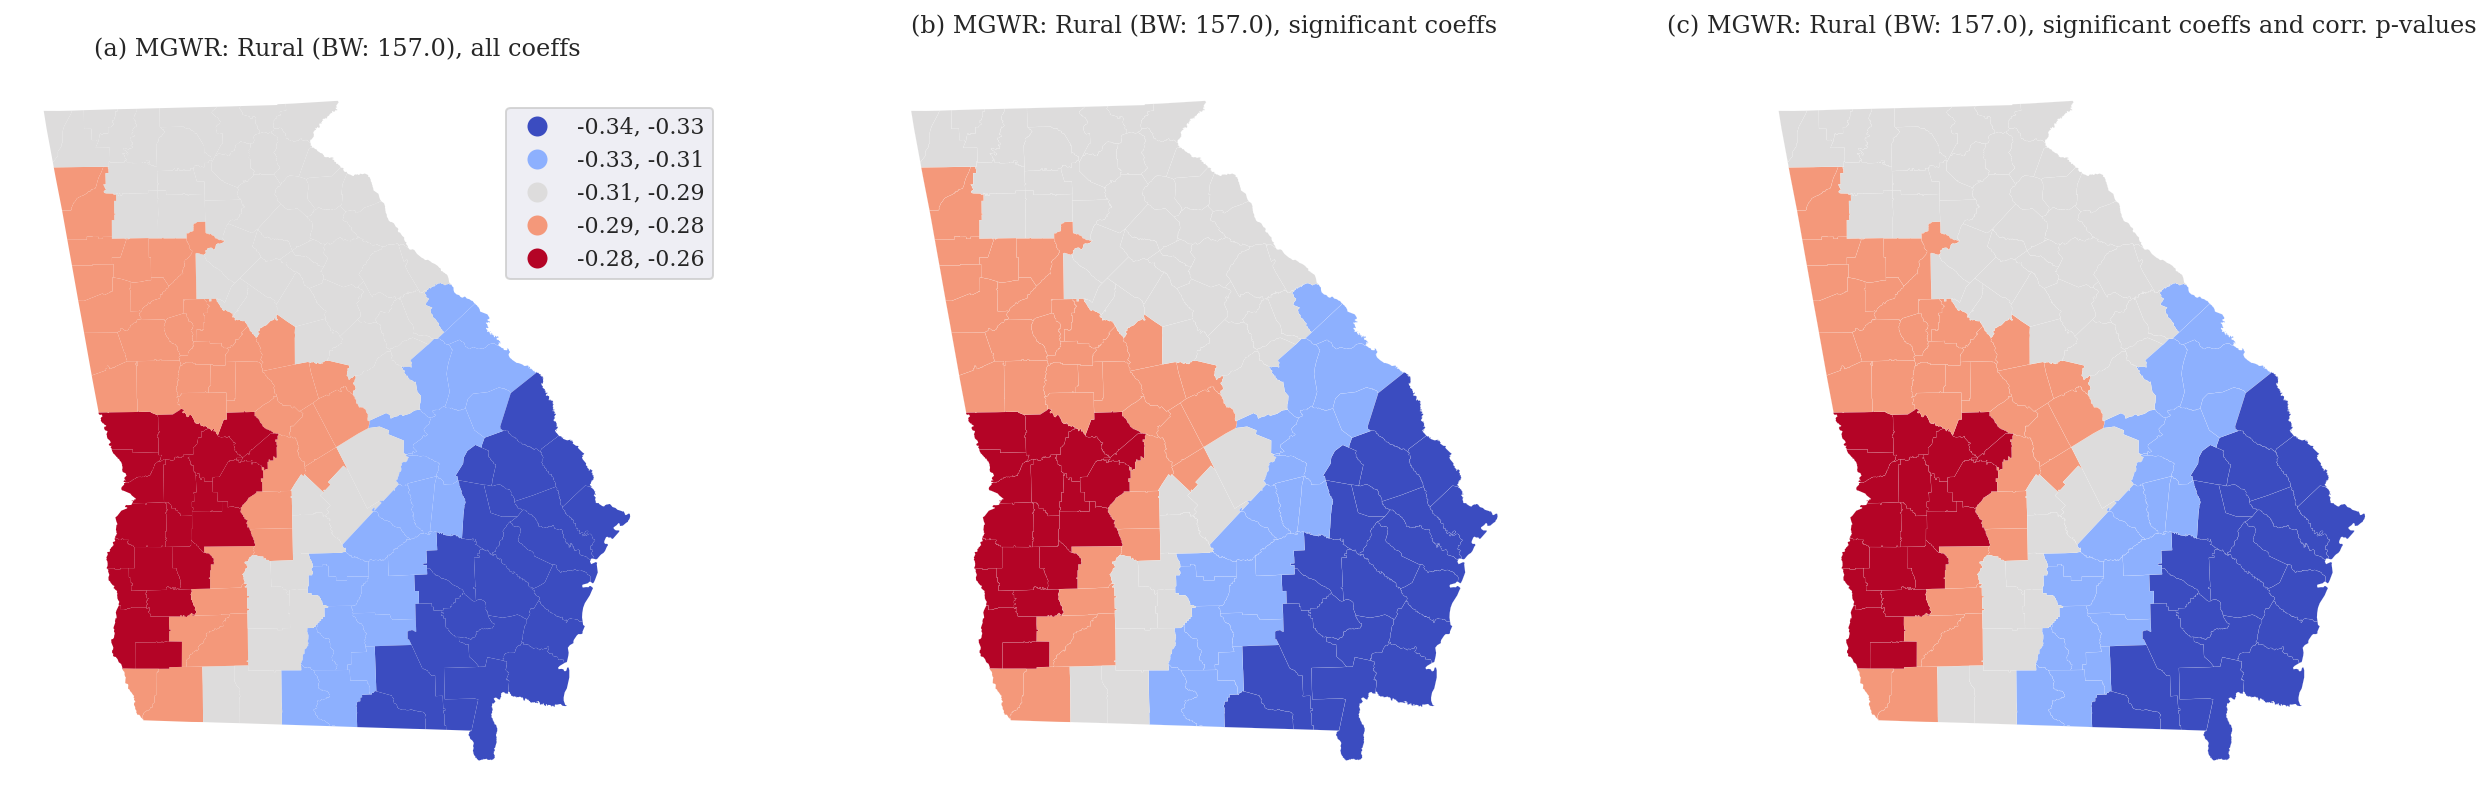

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

gdf.plot(column='mgwr_rural', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])

gdf.plot(column='mgwr_rural', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
gdf[mgwr_filtered_t[:,3] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


gdf.plot(column='mgwr_rural', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
gdf[mgwr_filtered_tc[:,3] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) MGWR: Rural (BW: ' + str(mgwr_bw[3]) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) MGWR: Rural (BW: ' + str(mgwr_bw[3]) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) MGWR: Rural (BW: ' + str(mgwr_bw[3]) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()

### Test spatial stationarity

In [40]:
%%time
# Monte Carlo test of spatial variability: 10 iterations 
mgwr_p_values_stationarity = mgwr_results.spatial_variability(mgwr_selector, 10)

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 44.6 s, sys: 8.38 s, total: 53 s
Wall time: 1min 5s


In [41]:
mgwr_p_values_stationarity
# Note:  The first p-value is for the intercept

array([0. , 0.1, 0.3, 0.9])

### Test local multicollinearity

In [42]:
mgwrCN, mgwrVDP = mgwr_results.local_collinearity()

In [43]:
gdf['mgwr_CN'] = mgwrCN

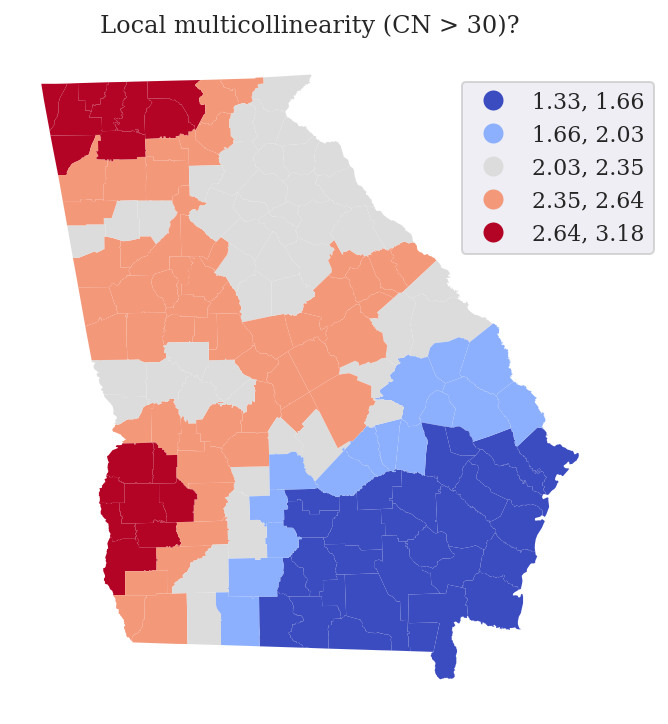

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(column='mgwr_CN', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local multicollinearity (CN > 30)?', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

## References

- Sachdeva, M., and Fotheringham, A. S. (2020). [The Geographically Weighted Regression Framework](https://gistbok.ucgis.org/bok-topics/geographically-weighted-regression-framework). The Geographic Information Science & Technology Body of Knowledge (4th Quarter 2020 Edition), John P. Wilson (Ed.). DOI: 10.22224/gistbok/2020.4.7 

- Oshan, T. M., Li, Z., Kang, W., Wolf, L. J., & Fotheringham, A. S. (2019). mgwr: A Python implementation of multiscale geographically weighted regression for investigating process spatial heterogeneity and scale. ISPRS International Journal of Geo-Information, 8(6), 269.

- Oshan, Taylor, Ziqi Li, Wei Kang, Levi J. Wolf, and Alexander S. Fotheringham. 2018. “Mgwr: A Python Implementation of Multiscale Geographically Weighted Regression for Investigating Process Spatial Heterogeneity and Scale.” OSF Preprints. October 2. doi: [10.31219/osf.io/bphw9](osf.io/bphw9).

- https://github.com/pysal/mgwr

- This notebook is largely inspired by: https://github.com/pysal/mgwr/blob/master/notebooks/MGWR_Georgia_example.ipynb